# **Tomato Leaf Classification**

---

<img src="https://creative-formulas.com/wp-content/uploads/2022/01/tomato-leaf-base.jpg" alt="Tomato Leaf" width="700" height="400"/>





In [1]:
# import numpy as np
import pickle
import cv2
import shutil
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [27]:
sns.set()

In [28]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 300


# Path to the dataset folder
dataset_dir = r'C:\Users\amani\ku_challenges\PlantVillage\plant_village_dataset'

In [29]:
def dataset_info(dataset) :
   # Dictionary to store image count per folder
    folder_image_count = {}

    try:
        # List all folders in the dataset directory
        plant_disease_folder_list = os.listdir(dataset)

        # Process each folder
        for plant_disease_folder in plant_disease_folder_list:
            folder_path = os.path.join(dataset_dir, plant_disease_folder)
            
            # Only process if it is a directory (folder)
            if os.path.isdir(folder_path):
            # print(f"[INFO] Processing {plant_disease_folder} ...")

                # List all images in the folder
                plant_disease_image_list = os.listdir(folder_path)

                # Filter out images with valid extensions (.jpg, .JPG)
                valid_images = [img for img in plant_disease_image_list if img.endswith(('.jpg', '.JPG'))]

                # Store the count of images for the folder
                folder_image_count[plant_disease_folder] = len(valid_images)

        print("[INFO] Image loading completed")
        
    except Exception as e:
        print(f"Error : {e}")

    # Print the number of images per folder
    for folder, count in folder_image_count.items():
        print(f"Folder: {folder}, Number of images: {count}")

    # Plot a bar chart for image count per folder
    plt.figure(figsize=(10, 6))
    plt.bar(folder_image_count.keys(), folder_image_count.values(), color='skyblue')
    plt.xticks(rotation=90)
    plt.xlabel("Folders (Labels)")
    plt.ylabel("Number of Images")
    plt.title("Number of Images per Folder (Class Label)")
    plt.tight_layout()
    plt.show()

[INFO] Image loading completed
Folder: Tomato_Bacterial_spot, Number of images: 2127
Folder: Tomato_Early_blight, Number of images: 1000
Folder: Tomato_healthy, Number of images: 1591
Folder: Tomato_Late_blight, Number of images: 1908
Folder: Tomato_Leaf_Mold, Number of images: 952
Folder: Tomato_Septoria_leaf_spot, Number of images: 1771
Folder: Tomato_Spider_mites_Two_spotted_spider_mite, Number of images: 1676
Folder: Tomato__Target_Spot, Number of images: 1404
Folder: Tomato__Tomato_mosaic_virus, Number of images: 373
Folder: Tomato__Tomato_YellowLeaf__Curl_Virus, Number of images: 3208


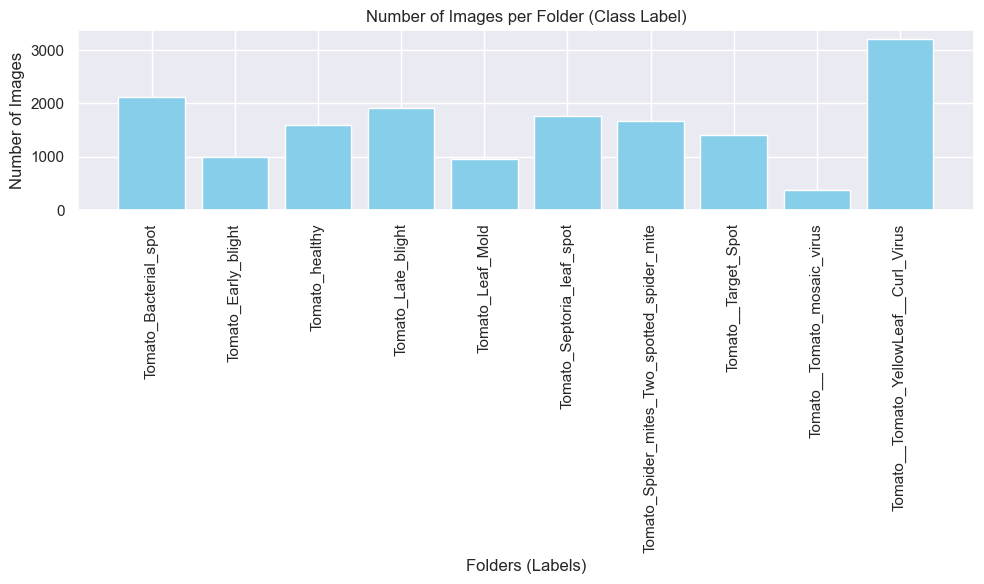

In [30]:
dataset_info(dataset_dir)

In [31]:
# Function to convert Images into array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [32]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(dataset_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{dataset_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{dataset_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed

Total number of images: 3000


In [33]:
# Save binary labels to pickle file

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

#pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  10


In [34]:
for classification in label_binarizer.classes_:
    print(classification)

Tomato_Bacterial_spot
Tomato_Early_blight
Tomato_Late_blight
Tomato_Leaf_Mold
Tomato_Septoria_leaf_spot
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato__Target_Spot
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato__Tomato_mosaic_virus
Tomato_healthy


In [35]:
np_image_list.shape

(3000, 256, 256, 3)

# Augment and Split Dataset

In [14]:
# augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
#                              height_shift_range=0.1, shear_range=0.2, 
#                              zoom_range=0.2, horizontal_flip=True, 
#                              fill_mode="nearest")

In [36]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 1) 

[INFO] Splitting data to train and test...


In [37]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(2400, 256, 256, 3)
(600, 256, 256, 3)
(2400, 10)
(600, 10)


In [38]:
EPOCHS = 10
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3
n_classes = len(label_binarizer.classes_)  


In [39]:
# Initialize optimizer
opt = Adam(lr=LR, decay=LR / EPOCHS)

c:\Users\amani\.conda\envs\dev\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [40]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 activation_7 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 85, 85, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 85, 85, 64)       

In [60]:
# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [61]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint("Models/CNN_tomato_disease_classification3.h5", monitor="val_loss", save_best_only=True, save_weights_only=True)


In [62]:
# Train the model with the checkpoint callback
history = model.fit(x_train, y_train, 
                    validation_data=(x_test, y_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/10
75/75 [==============================] - 54s 713ms/step - loss: 0.2698 - accuracy: 0.6146 - val_loss: 5.0959 - val_accuracy: 0.1967
Epoch 2/10
75/75 [==============================] - 58s 776ms/step - loss: 0.1690 - accuracy: 0.7250 - val_loss: 0.7424 - val_accuracy: 0.3217
Epoch 3/10
75/75 [==============================] - 57s 761ms/step - loss: 0.1287 - accuracy: 0.8008 - val_loss: 0.4227 - val_accuracy: 0.3450
Epoch 4/10
75/75 [==============================] - 57s 756ms/step - loss: 0.1091 - accuracy: 0.8346 - val_loss: 0.1873 - val_accuracy: 0.6883
Epoch 5/10
75/75 [==============================] - 58s 772ms/step - loss: 0.1016 - accuracy: 0.8433 - val_loss: 0.1545 - val_accuracy: 0.7233
Epoch 6/10
75/75 [==============================] - 59s 793ms/step - loss: 0.0829 - accuracy: 0.8692 - val_loss: 0.2630 - val_accuracy: 0.6100
Epoch 7/10
75/75 [==============================] - 55s 736ms/step - loss: 0.0755 - accuracy: 0.8933 - val_loss: 0.6053 - val_accuracy: 0.3567

In [63]:
model.evaluate(x_test,y_test)
# CNN_tomato_disease_classification3 has the best accuraacy so far

19/19 [==============================] - 3s 148ms/step - loss: 0.0828 - accuracy: 0.8733


[0.08284955471754074, 0.8733333349227905]

In [64]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 activation_28 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_24 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 85, 85, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 85, 85, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 85, 85, 64)       

In [65]:
# Load the weights from the last checkpoint
model.load_weights("Models/CNN_tomato_disease_classification3.h5")

In [66]:
# Compile the model again (if not compiled)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [67]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint("Models/CNN_tomato_disease_classification4.h5", monitor="val_loss", save_best_only=True, save_weights_only=True)


In [68]:
# Continue training
# Train the model with the checkpoint callback
history = model.fit(x_train, y_train, 
                    validation_data=(x_test, y_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/10
75/75 [==============================] - 101s 1s/step - loss: 0.1272 - accuracy: 0.8004 - val_loss: 2.4736 - val_accuracy: 0.2800
Epoch 2/10
75/75 [==============================] - 60s 808ms/step - loss: 0.0962 - accuracy: 0.8562 - val_loss: 0.8663 - val_accuracy: 0.4133
Epoch 3/10
75/75 [==============================] - 80s 1s/step - loss: 0.0802 - accuracy: 0.8708 - val_loss: 0.6250 - val_accuracy: 0.4417
Epoch 4/10
75/75 [==============================] - 90s 1s/step - loss: 0.0631 - accuracy: 0.9158 - val_loss: 0.4314 - val_accuracy: 0.3583
Epoch 5/10
75/75 [==============================] - 137s 2s/step - loss: 0.0495 - accuracy: 0.9396 - val_loss: 0.8298 - val_accuracy: 0.3967
Epoch 6/10
75/75 [==============================] - 65s 843ms/step - loss: 0.0427 - accuracy: 0.9513 - val_loss: 0.1762 - val_accuracy: 0.7500
Epoch 7/10
75/75 [==============================] - 55s 730ms/step - loss: 0.0382 - accuracy: 0.9533 - val_loss: 0.1024 - val_accuracy: 0.8517
Epoch 8/1

In [69]:
model.evaluate(x_test,y_test)

19/19 [==============================] - 3s 147ms/step - loss: 0.1034 - accuracy: 0.8550


[0.10343492031097412, 0.8550000190734863]

In [70]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 85.50%


In [71]:
y_pred = model.predict(x_test)


19/19 [==============================] - 3s 151ms/step


In [72]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [73]:
cm = confusion_matrix(y_test_labels, y_pred_labels)


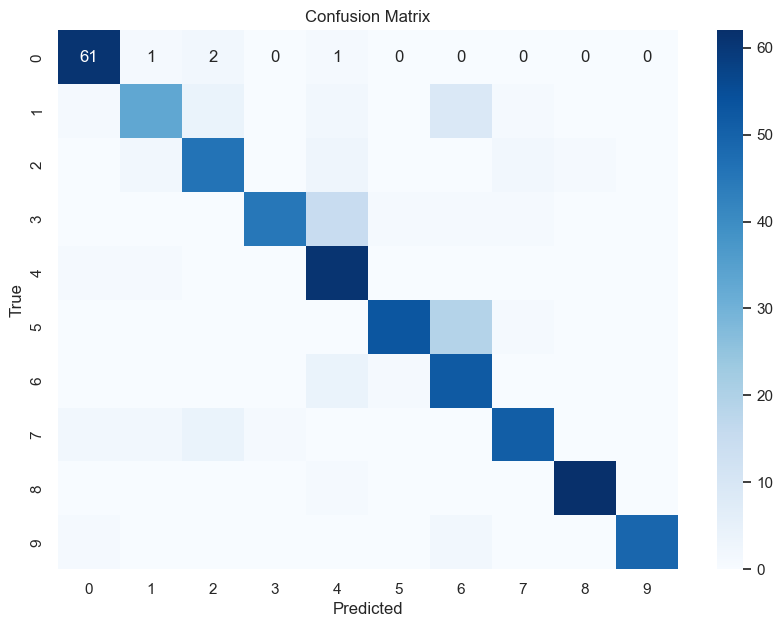

In [74]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Test Model

In [92]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict(np_image)
      # Get the predicted class index
    predicted_class_index = np.argmax(result, axis=1)[0]
    
    # Print the predicted class label
    predicted_class_label = label_binarizer.classes_[predicted_class_index]
    print(f"Predicted Disease: {predicted_class_label}")

1/1 [==============================] - 0s 26ms/step
Predicted Disease: Tomato_Early_blight


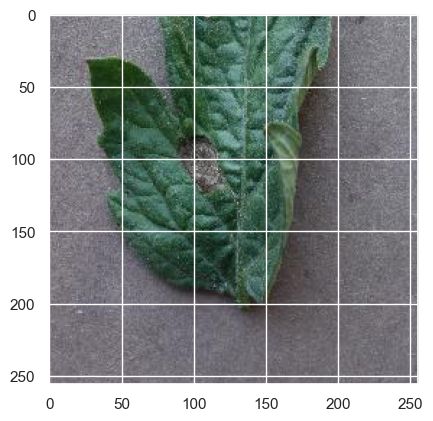

In [93]:
predict_disease(r"C:\Users\amani\ku_challenges\PlantVillage\plant_village_dataset\Tomato_Early_blight\0cd1ebaf-3975-4749-b625-50b7b0751c36___RS_Erly.B 7508.JPG")

1/1 [==============================] - 0s 26ms/step
Predicted Disease: Tomato_Leaf_Mold


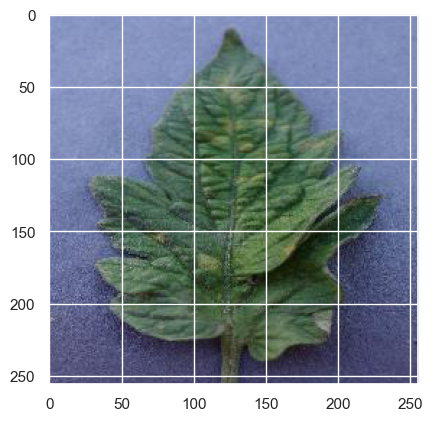

In [95]:
predict_disease(r"C:\Users\amani\ku_challenges\PlantVillage\plant_village_dataset\Tomato_Leaf_Mold\0ced0bae-d224-43f5-8fd7-072c7cbd8f77___Crnl_L.Mold 9161.JPG")

In [2]:
# Path to the saved model
model_path = 'Models/NeuralNetByAmanuel.h5'

# Load the model
model = load_model(model_path)
print("[INFO] Model loaded successfully.")

[INFO] Model loaded successfully.
